In [1]:
# Modules and settings
import importlib
import matplotlib.pyplot as plt 
import numpy as np
import rasterio
import sys
import os
import warnings
import xarray as xr

from pysheds.grid import Grid
sys.path.append("..")
from models import STREAM_model as STREAM 
# Hide warnings regarding nans in coditional statements 
np.seterr(invalid='ignore')
warnings.filterwarnings('ignore')

#%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
# Parameters
dischargepointrow = 173
dischargepointcolumn = 198
pixelsize = 1140
timestep = 24*3600*30

In [3]:
# Start and end time of iteration
timestart = 1020   # Start month of simulation (Jan 1908)
timeend = 1260  # End month of simulation (dec 1920)

Create list of months and years of the full extend of the data. Open *year_list* and *month_list* in the Variable Inspector (right-click to open) after running the next cell to check what is in these lists (i.e. what is calculated in the next cell).

In [4]:
start_year = 1901
end_year = 2023
start_month = 0    # January 
end_month = 12     #December 

month_list, year_list = STREAM.set_dates(start_year, end_year, start_month, end_month)

In [5]:

# Define the input directory path once
input_dir = os.path.join('..', 'models', 'Input_file')

# read Land characteristics files
C      = rasterio.open(os.path.join(input_dir, 'Slope_class_v4.tif')).read()[0] # Slope class map
C[np.isnan(C)] = 4
Cropf  = rasterio.open(os.path.join(input_dir, 'CropFactor_v5.tif')).read()[0]  # Crop Factor map
#Cropf = Cropf / 10 #Adjust Crop factor values if necessary
Wholdn = rasterio.open(os.path.join(input_dir, 'WHC.tif')).read()[0]    # Water holding capacity map
Wholdn[Wholdn == -9999] = 5 
DEM    = rasterio.open(os.path.join(input_dir, 'DEM.tif')).read()[0]        # Digital Elevation Model
# read initial storage files
Aw     = np.ones_like(DEM)
Gw     = np.ones_like(DEM)
Snow   = np.ones_like(DEM)


Temperature   = xr.open_dataset(os.path.join(input_dir, 'temp_subset.dat.nc')).to_array().values[0]
A             = xr.open_dataset(os.path.join(input_dir, 'A_resampled.nc')).to_array().values[0]
Precipitation = xr.open_dataset(os.path.join(input_dir, 'precipitation_subset.dat.nc')).to_array().values[0]
Heat          = xr.open_dataset(os.path.join(input_dir, 'HEAT_resampled.nc')).to_array().values[0]
Heat[Heat == 0] = 32.0  # Adjust heat values of zero to a mean of 32

In [6]:
Heat[Heat == 0] = 32.0  # Adjust heat values of zero to a mean of 32

In [7]:
#import matplotlib.pyplot as plt

# Display a single map
#.figure(figsize=(10, 8))
#plt.imshow(DEM, cmap='terrain')
#plt.colorbar(label='Elevation (m)')
#plt.title('Digital Elevation Model')
#plt.show()

# plt.figure(figsize=(10, 8))
# plt.imshow(C, cmap='YlGn')
# plt.colorbar(label='slope class (%)')
# plt.title('Digital Elevation Model')
# plt.show()

# # Display multiple maps side by side
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# axes[0, 0].imshow(C, cmap='viridis')
# axes[0, 0].set_title('Slope Class')
# axes[0, 0].axis('on')


# axes[0, 1].imshow(Cropf, cmap='YlGn')
# axes[0, 1].set_title('Crop Factor')
# axes[0, 1].axis('off')

# axes[1, 0].imshow(Wholdn, cmap='Blues')
# axes[1, 0].set_title('Water Holding Capacity')
# axes[1, 0].axis('off')

# axes[1, 1].imshow(DEM, cmap='terrain')
# axes[1, 1].set_title('DEM')
# axes[1, 1].axis('off')

# plt.tight_layout()
# plt.legend()
# plt.show()

In [8]:
input_dir = os.path.join('..', 'models', 'Input_file')
dem_path = os.path.join(input_dir, 'DEM.tif')

# Use it for all file reads
grid = Grid.from_raster(dem_path)
dem_grid = grid.read_raster(dem_path)

# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem_grid)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# Load the same DEM for STREAM model
DEM = rasterio.open(dem_path).read()[0]


In [9]:
#setup the model and pass all the relevant information to the model setup function. 
importlib.reload(STREAM)

elbe = STREAM.Setup_model(dischargepointrow, dischargepointcolumn, pixelsize,
                              timestep, C, Cropf, Wholdn, Aw, Gw, Snow,
                              Precipitation, Temperature, Heat, A, grid, fdir, dirmap,
                              month_list, year_list)

Calibrating the model
We use the following variables in our model: \
*GW*     = Groundwater \
*Tmp*    = Temperature \
*Pe*     = Potential evapotranspiration \
*Pre*    = Precipitation \
*Excess* = Excess water, or surface runoff after evaporation and saturation of the soil \
*Aw*     = Available water (for plants) in the soil   \
*Runoff* = Runoff (both surface and subsurface) that leaves the grid cell. This is not accumulated/routed yet. \
*Qsec*   = routed or accumulated discharge in cubic meters per second. \

In [10]:
# elbe.model_flow(timestart=timestart, timeend=timeend, P_change=1, T_change=0)

# TimeseriesGw     = elbe.TimeseriesGw['Gw']
# TimeseriesTmp    = elbe.TimeseriesTmp['Tmp']
# TimeseriesPe     = elbe.TimeseriesPe['Pe']
# TimeseriesPre    = elbe.TimeseriesPre['Pre']
# TimeseriesExcess = elbe.TimeseriesExcess['Excess']
# TimeseriesAw     = elbe.TimeseriesAw['Aw']
# TimeseriesRunoff = elbe.TimeseriesRunoff['Runoff']
# TimeseriesQsec   = elbe.TimeseriesQsec['Qsec']

In [11]:
# import pandas as pd

# # Create a dataframe to inspect all timeseries
# df = pd.DataFrame({
#     'Qsec': TimeseriesQsec,
#     'Runoff': TimeseriesRunoff,
#     'Aw': TimeseriesAw,
#     'Excess': TimeseriesExcess,
#     'Pe': TimeseriesPe,
#     'Gw': TimeseriesGw,
#     'Tmp': TimeseriesTmp,
#     'Pre': TimeseriesPre
# })

# #hidden unless needed
# #print(df.describe())
# #print("\n", df.head(10))
# #print("\n", df.tail(10))

In [12]:
# import numpy as np

# def describe(arr, name):
#     print(f"\n{name}")
#     print(" shape:", arr.shape)
#     print(" min:", np.nanmin(arr))
#     print(" max:", np.nanmax(arr))
#     print(" mean:", np.nanmean(arr))
#     print(" n_nans:", np.isnan(arr).sum())

# describe(Temperature, "Temperature")
# describe(A, "A (area or albedo?)")
# describe(Precipitation, "Precipitation")
# describe(Cropf, "Cropf")
# describe(DEM, "DEM")
# describe(C, "C")
# describe(Wholdn, "Wholdn")


In [13]:
# #patterns we can detect for each variable 
# %matplotlib inline
# importlib.reload(STREAM)
# elbe.plot_series()

In [14]:
# elbe.model_flow(timestart=timestart, timeend=timeend, P_change=1, T_change=0)
# qstation = elbe.TimeseriesQsec
# qstation.to_excel('calibration.xlsx')

In [15]:
# controle_qlist = elbe.Qsec_list
# controle_qlist_np = np.array(controle_qlist)

# list_13 = controle_qlist[13]
# list_13_np = np.array(list_13)

# np.savetxt("foo2.csv", list_13_np, delimiter=",")

In [16]:
 # Adjusting Calibration parameters
elbe.HEATcal   = 1.0     # Not used in this practical: default=1 [>0]
elbe.WHOLDNcal = 1.5     # Water holding capacity of the soil: default=1 [>0]
elbe.MELTcal   = 12   # How fast snow melts: default=10 [>0]
elbe.CROPFcal  = 0.57     # Parameter steering the evapotranspiration: default=1 [>0]
elbe.TOGWcal   = 0.2     # Parameter seperating the fraction going to groundwater and direct runoff: default=0.4 [0-1]
elbe.Ccal      = 1.7     # Parameter steering how fast groundwater flows: default=1 [>1]

climate_change_select_args = {"SSP1_Tchange": {"P_change": 1.0, "T_change": 1.75}, 
                              "SSP1_Pchange": {"P_change": 1.11, "T_change": 0}, 
                              "SSP1_combi": {"P_change": 1.11, "T_change": 1.75}, 
                              "SSP2_combi": {"P_change": 1.11, "T_change": 2.5},
                              "SSP3_combi": {"P_change": 1.05, "T_change": 4.5}, 
                              "SSP5_T_change": {"P_change": 1.0, "T_change": 6.0}, 
                              "SSP5_Pchange": {"P_change": 1.05, "T_change": 0},
                              "SSP5_combi": {"P_change": 1.05, "T_change": 6.0}
                              }

elbe.model_flow(timestart=timestart, timeend=timeend, P_change=1, T_change=0)
no_change_qstation = elbe.TimeseriesQsec
no_change_pstation = elbe.TimeseriesPre
no_change_tstation = elbe.TimeseriesTmp

output_scenarios = {}
for scenario, args in climate_change_select_args.items():
    print(f"Running scenario: {scenario} with args: {args}")
    elbe.model_flow(timestart=timestart, timeend=timeend, 
                    P_change=args["P_change"], 
                    T_change=args["T_change"])
    
    qstation = elbe.TimeseriesQsec
    pstation = elbe.TimeseriesPre
    tstation = elbe.TimeseriesTmp

    output_scenarios[scenario] = {"qstation": qstation, 
                                  "pstation": pstation, 
                                  "tstation": tstation}

# TimeseriesGw     = elbe.TimeseriesGw['Gw']
# TimeseriesTmp    = elbe.TimeseriesTmp['Tmp']
# TimeseriesPe     = elbe.TimeseriesPe['Pe']
# TimeseriesPre    = elbe.TimeseriesPre['Pre']
# TimeseriesExcess = elbe.TimeseriesExcess['Excess']
# TimeseriesAw     = elbe.TimeseriesAw['Aw']
# TimeseriesRunoff = elbe.TimeseriesRunoff['Runoff']
# TimeseriesQsec   = elbe.TimeseriesQsec['Qsec']

# Save to Excel
# qstation = elbe.TimeseriesQsec
# qstation.to_excel(f'calibration_{scenario}.xlsx')

100%|██████████| 240/240 [00:14<00:00, 16.55it/s]


Running scenario: SSP1_Tchange with args: {'P_change': 1.0, 'T_change': 1.75}


100%|██████████| 240/240 [00:14<00:00, 16.92it/s]


Running scenario: SSP1_Pchange with args: {'P_change': 1.11, 'T_change': 0}


100%|██████████| 240/240 [00:14<00:00, 16.99it/s]


Running scenario: SSP1_combi with args: {'P_change': 1.11, 'T_change': 1.75}


100%|██████████| 240/240 [00:14<00:00, 17.05it/s]


Running scenario: SSP2_combi with args: {'P_change': 1.11, 'T_change': 2.5}


100%|██████████| 240/240 [00:14<00:00, 16.87it/s]


Running scenario: SSP3_combi with args: {'P_change': 1.05, 'T_change': 4.5}


100%|██████████| 240/240 [00:14<00:00, 16.66it/s]


Running scenario: SSP5_T_change with args: {'P_change': 1.0, 'T_change': 6.0}


100%|██████████| 240/240 [00:14<00:00, 16.49it/s]


Running scenario: SSP5_Pchange with args: {'P_change': 1.05, 'T_change': 0}


100%|██████████| 240/240 [00:14<00:00, 16.69it/s]


Running scenario: SSP5_combi with args: {'P_change': 1.05, 'T_change': 6.0}


100%|██████████| 240/240 [00:14<00:00, 16.32it/s]


In [17]:
# import pandas as pd

# elbe.model_flow(timestart=timestart, timeend=timeend, P_change=1, T_change=0)
# P_station = elbe.TimeseriesPre_act
# # qstation.to_excel('pre_check.xlsx')

# TimeseriesGw     = elbe.TimeseriesGw['Gw']
# TimeseriesTmp    = elbe.TimeseriesTmp['Tmp']
# TimeseriesPe     = elbe.TimeseriesPe['Pe']
# TimeseriesPre    = elbe.TimeseriesPre['Pre']
# TimeseriesExcess = elbe.TimeseriesExcess['Excess']
# TimeseriesAw     = elbe.TimeseriesAw['Aw']
# TimeseriesRunoff = elbe.TimeseriesRunoff['Runoff']
# TimeseriesQsec   = elbe.TimeseriesQsec['Qsec']

# sim_time = range(timestart, timeend)
# year = [start_year + x // 12 for x in sim_time]
# P_station['year'] = year

# ann_sum = P_station.groupby('year').sum()
# ann_avg = ann_sum["Pre"].mean()

# print(f"The average precipitation over 1986-2005 is: {ann_avg} mm/month")

# print("1", ((0.1 * 24 * 30) / ann_avg))
# print("2", ((0.1* 24 * 30) / ann_avg))
# print("3", ((0.05* 24 * 30) / ann_avg))
# print("5", ((0.05* 24 * 30) / ann_avg))

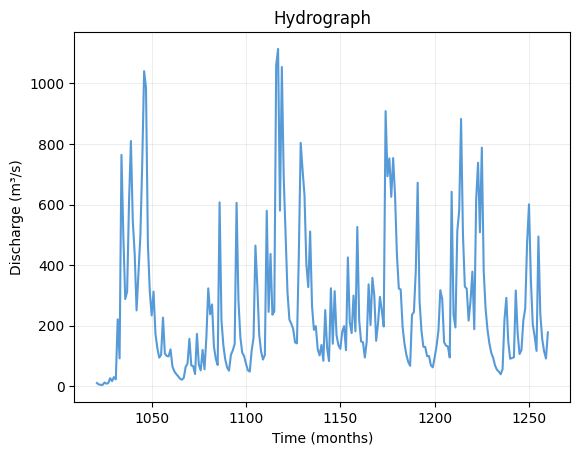

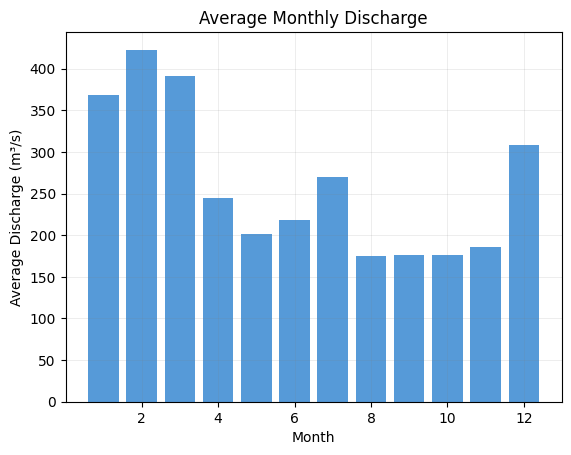

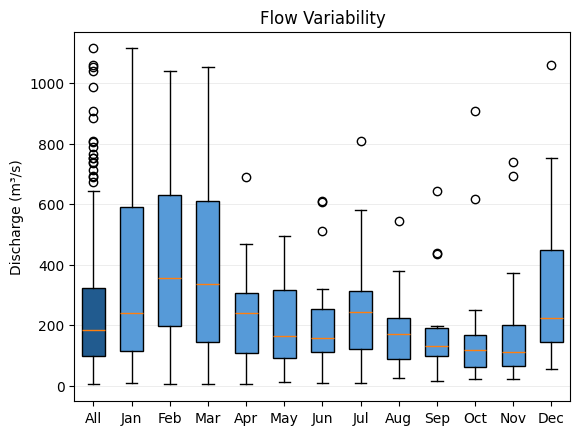

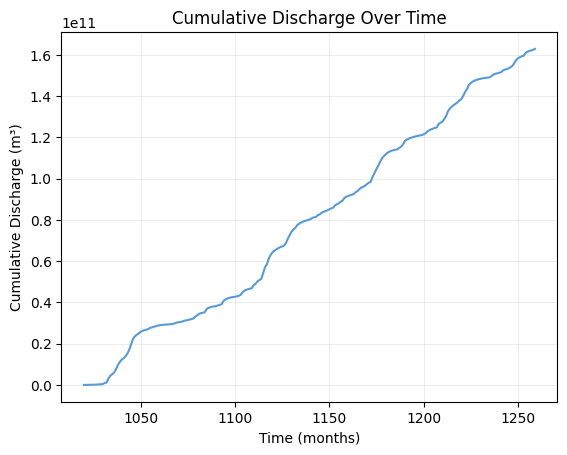

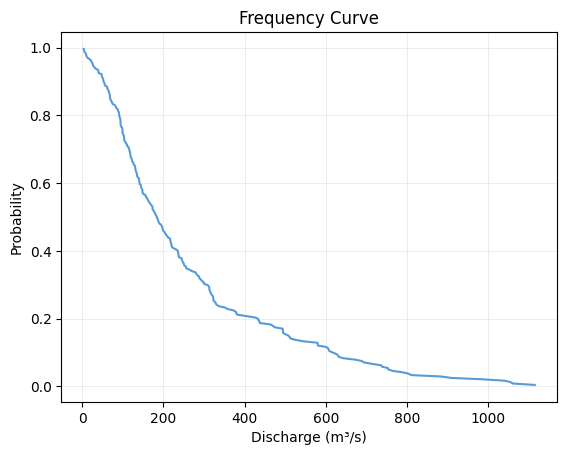

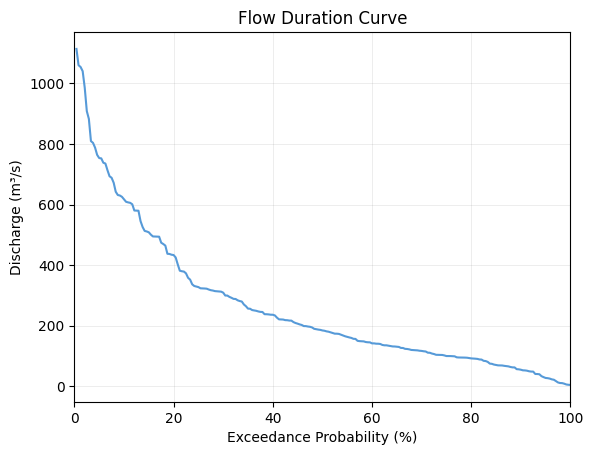

In [18]:
# importlib.reload(STREAM)
fig_hydrograph = elbe.plot_hydrograph()
fig_Q_avg = elbe.plot_average_discharge()
fig_flow_var = elbe.plot_flow_variability()
fig_flow_cum = elbe.plot_cumulative_discharge()
fig_flow_freq = elbe.plot_frequency_curve()
fig_flow_dur = elbe.plot_flow_duration_curve()

fig_hydrograph.show()
fig_Q_avg.show()
fig_flow_var.show()
fig_flow_cum.show()
fig_flow_freq.show()
fig_flow_dur.show()

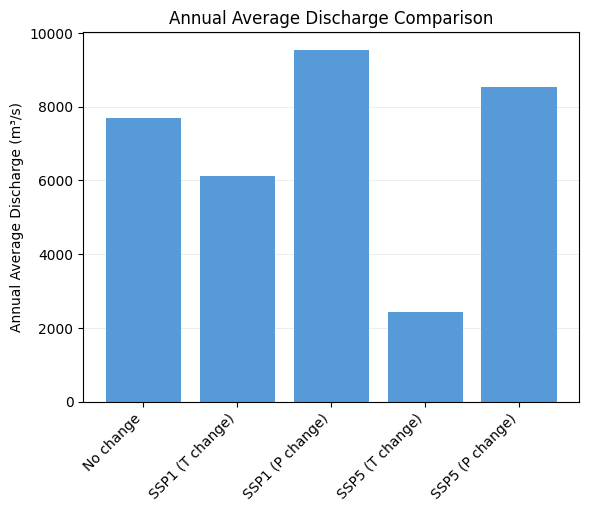

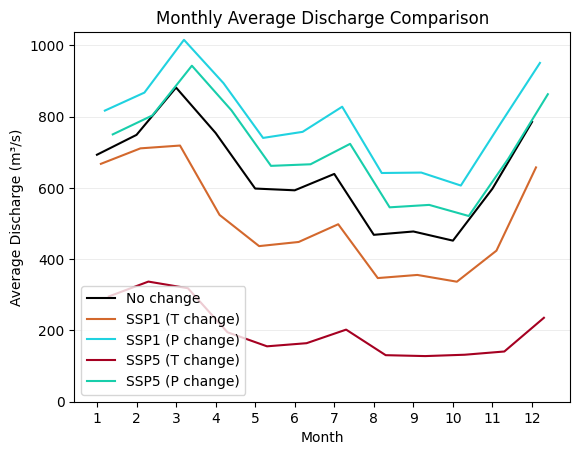

In [45]:
#     output_scenarios[scenario] = {"qstation": qstation, 
#                                   "pstation": pstation, 
#                                   "tstation": tstation}
importlib.reload(STREAM)
SSP1_Tchange_q = output_scenarios["SSP1_Tchange"]["qstation"]
SSP1_Pchange_q = output_scenarios["SSP1_Pchange"]["qstation"]
SSP5_Tchange_q = output_scenarios["SSP5_T_change"]["qstation"]
SSP5_Pchange_q = output_scenarios["SSP5_Pchange"]["qstation"]

# importlib.reload(STREAM)
list_of_runs_sep = [no_change_qstation, SSP1_Tchange_q, SSP1_Pchange_q, SSP5_Tchange_q, SSP5_Pchange_q]
list_of_labels_sep = ['No change', 'SSP1 (T change)', 'SSP1 (P change)', 'SSP5 (T change)', 'SSP5 (P change)']
list_of_colors_sep = ['black', '#D3682D', '#20D2E0', '#A50021', '#18CEAB']


fig_annual_avg = STREAM.yearly_average_comparison(start_year, timestart, timeend, list_of_runs_sep, list_of_labels_sep)
fig_monthly_avg = STREAM.monthly_average_comparison(timestart, timeend, list_of_runs_sep, list_of_labels_sep, list_of_colors_sep)

fig_annual_avg.show()
fig_monthly_avg.show()

# STREAM.fig_download(fig_climate, filename='climate_run')